In [19]:
import numpy as np
import astropy.io.fits
import random
import os
import os.path
import cv2
import collections
from collections import Counter
from PIL import Image
from sklearn.cluster import KMeans
from astropy.time import Time
import csv
from statistics import stdev
from statistics import mean
import math
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import timeit

In [2]:
# Normalizing between [1,-1]
def normal(a):
    
    aa = a - a.min()
    bb = a.max() - a.min()
    cc = (2 * aa) / bb
    dd = cc - 1
    return dd


# Unnormal

def unnormal(norm, pure):
    ee = norm + 1
    ff = ee/2
    gg = ff * (pure.max() - pure.min())
    hh = gg + pure.min()
    return hh


# Getting Features

def getFeatures(Name):
    fileData = astropy.io.fits.open(Name)
    B = fileData[1].data
    B = np.array(B, dtype=np.float32)
    Binc = fileData[2].data
    Binc = np.array(Binc, dtype=np.float32)
    Bazi = fileData[3].data
    Bazi = np.array(Bazi, dtype=np.float32)
    DopF = fileData[4].data
    DopF = np.array(DopF, dtype=np.float32)
    #DopS = fileData[5].data
    #DopS = np.array(DopS, dtype=np.float64)
    SLFF = fileData[12].data
    SLFF = np.array(SLFF, dtype=np.float32)
    CI = fileData[32].data
    CI = np.array(CI, dtype=np.float32)


    return B, Binc, Bazi, DopF, SLFF, CI


# Removing that effect due to doppler shifts

def canNoise(Doppler):
    
    y = np.mean(Doppler, 0)
    x = np.array(range(Doppler.shape[1]))
    m, b = np.polyfit(x, y, 1)
    v = m*x + b
    out = Doppler - v

    return out

# Normalizing angles

def normangle(feature):
    
    
    a = np.cos(np.deg2rad(feature))
    
    return a
      

# Making a list for dimensions of observations
def dimlist(filenames):
    
    dimList = list()


    for i in NewList:

        file = astropy.io.fits.open(i)
        x, y = file[1].data.shape
        dimList.append((x, y))
    
    return dimList


# Concatenating all the observations

def concatfeatures(NewList):

    Btot, Binctot, DopFtot, SLFFtot, CItot = np.array([]), np.array([]),np.array([]), np.array([]),np.array([])



    for j in NewList:

        B, Binc, Bazi, DopF, SLFF, CI = getFeatures(j)
        Btot = np.concatenate((Btot, B), axis=None)
        Binctot = np.concatenate((Binctot, Binc), axis=None)
        DopFtot = np.concatenate((DopFtot, canNoise(DopF)), axis=None)
        SLFFtot = np.concatenate((SLFFtot, SLFF), axis=None)
        CItot = np.concatenate((CItot, CI), axis=None)
    
    
    return Btot, Binctot, DopFtot, SLFFtot, CItot

#Concateraw
def conpure(NewList):

    Btot, DopFtot, SLFFtot, CItot = np.array([]),np.array([]), np.array([]),np.array([])

    for j in NewList:

        B, Binc, Bazi, DopF, SLFF, CI = getFeatures(j)
        Btot = np.concatenate((Btot, B), axis=None)
        DopFtot = np.concatenate((DopFtot, DopF), axis=None)
        SLFFtot = np.concatenate((SLFFtot, SLFF), axis=None)
        CItot = np.concatenate((CItot, CI), axis=None)
    
    
    return Btot, DopFtot, SLFFtot, CItot


# Plot mappings
def pltmaps(labels, dimList, k):
    
    start = 0
    end = 0

    for s, tple in enumerate(dimList):

        end += tple[0] * tple[1]

        pltimg(labels[start:end], tple, s)

        start = end 
        
def pltimg(labels, tple, s):
    
    fileData = (NewList[s])
    v = fileData[42:-5]
    labless = labels.reshape(tple)
    plt.figure(figsize=(16,9))
    plt.imshow(labless, cmap="plasma", origin="bottom")
    plt.colorbar()
    plt.savefig(dir+'/'+ v + '.png')
    plt.close()
    

In [3]:
NorthDir='/glade/work/egeland/hinode_synoptic/north'
allfiles = [os.path.join(NorthDir, f) for f in sorted(os.listdir(NorthDir))]

# Removing all sav files
NewList=[item for i,item in enumerate(allfiles) if i%2==0]


b = []

for item in NewList:
    
    fileData = astropy.io.fits.open(item)
    a = fileData[0].header['YSCALE']
    if a > 0.16 :
        b.append(item)

NewList = []       
NewList = b

dimList = dimlist(NewList)
Btot, Binctot, DopFtot, SLFFtot, CItot = concatfeatures(NewList)

In [4]:
f1un = np.multiply(Btot, SLFFtot)
f1un = np.multiply(f1un, Binctot)
f2un = CItot

In [5]:
Btotn = normal(Btot)
Binctotn = normangle(Binctot)
DopFtotn = normal(DopFtot)
SLFFtotn = normal(SLFFtot)
CItotn = normal(CItot)

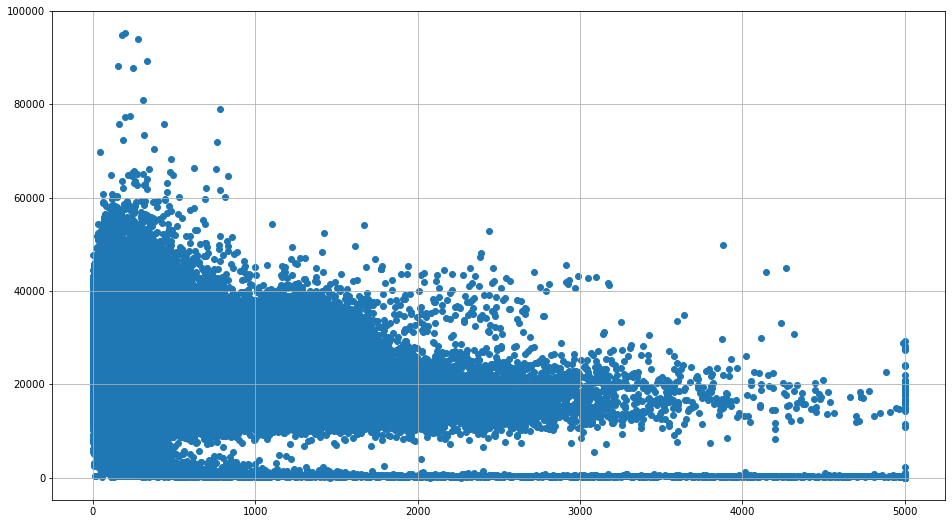

In [6]:
g1 = Btot
g2 = CItot

fig = plt.figure(figsize=(16,9))
plt.scatter(g1, g2)
plt.grid()
plt.show()
fig.savefig('visdataun.png')

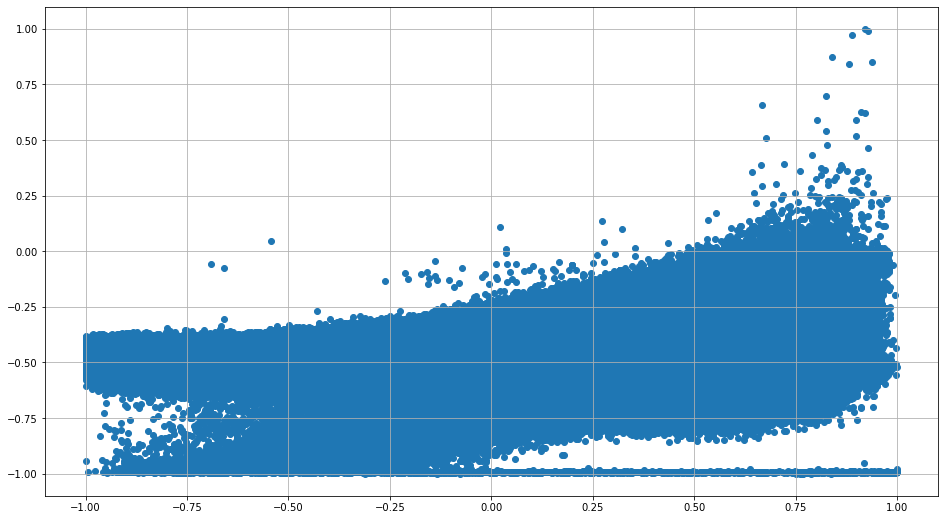

In [7]:
f1 = np.multiply(Btotn, SLFFtotn)
f1 = np.multiply(f1, normangle(Binctotn))
f2 = CItotn

fig = plt.figure(figsize=(16,9))
plt.scatter(f1, f2)
plt.grid()
plt.show()
fig.savefig('visdata.png')


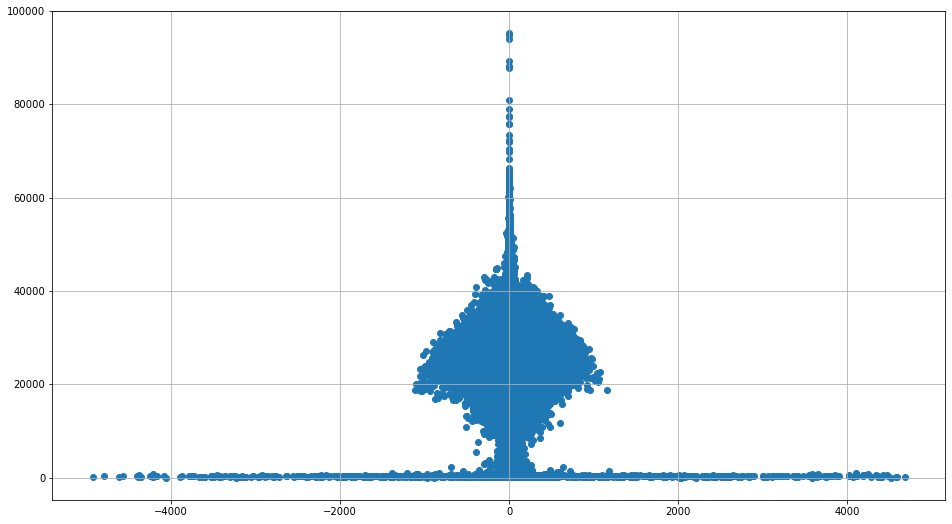

In [9]:
f1un = np.multiply(Btot, SLFFtot)
f1un = np.multiply(f1un, normangle(Binctot))
f2un = CItot

fig = plt.figure(figsize=(16,9))
plt.scatter(f1un, f2un)
plt.grid()
plt.show()
fig.savefig('visdataunnormal.png')

In [10]:
da = np.array([f1, f2])
fda = np.transpose(da)

In [11]:
gak_km = KMeans(n_clusters=5).fit(fda)

In [12]:
labels = gak_km.labels_

In [13]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

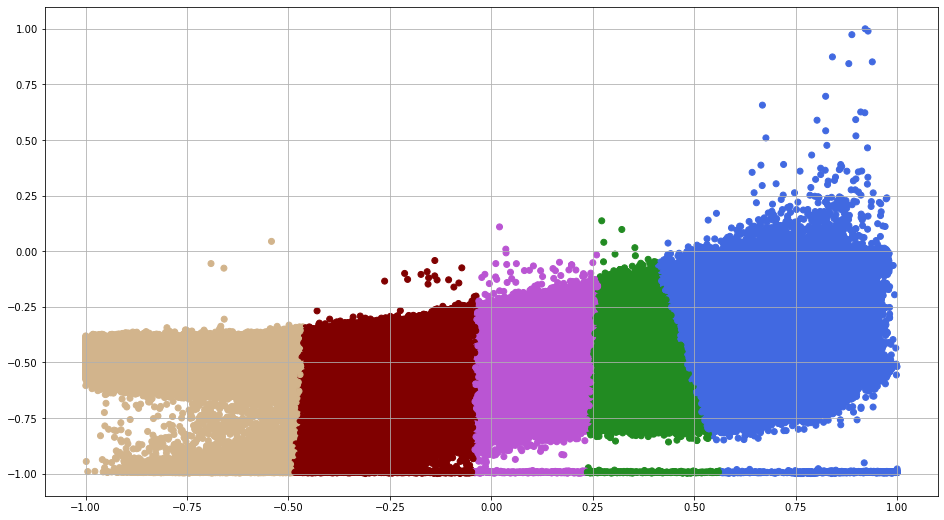

In [14]:
fig = plt.figure(figsize=(16,9))
plt.scatter(f1, f2, c=vectorizer(labels))
plt.grid()
plt.show()
fig.savefig('visdatalabels.png')

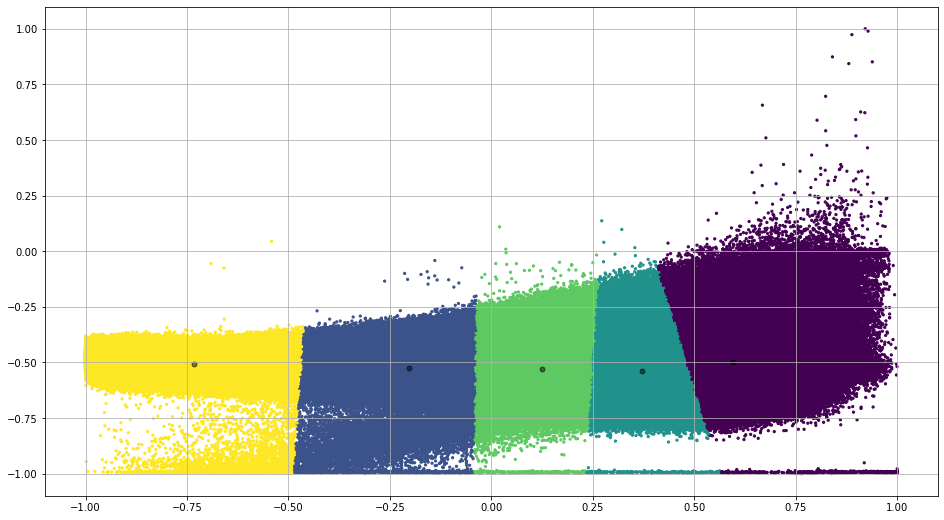

In [15]:
fig = plt.figure(figsize=(16,9))
plt.scatter(f1, f2, c=labels, s=5, cmap='viridis')

centers = gak_km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=25, alpha=0.5)
plt.grid()
plt.show()
fig.savefig('visdatalabels.png')

In [16]:
k = 5
dir = "cluster"+ str(k)
os.mkdir(dir)

labels = gak_km.labels_
centers = gak_km.cluster_centers_
cn = np.transpose(centers)

cn[cn < -1] = -1
cn[cn > 1] = 1

clcode = np.array(range(k))
Bn = unnormal(cn[0], f1un)
CIn = unnormal(cn[1], f2un)

cntrs = np.transpose(np.array([clcode, Bn, CIn]))





vv = cntrs[cntrs[:,1].argsort()]
neworder = np.array(range(1, k+1)).reshape(k,1)


cntrs = np.append(neworder, vv, axis = 1)




nwordr = vv[:,0]

gg = 1000
for ff in nwordr:
    labels[labels==ff] = gg
    gg += 1000

labels = labels/1000


count = collections.Counter(labels)
print(count)
mmbr = np.array([])

for i in range(1,k+1):
    mmbr = np.append(mmbr, count[i])
    
    
print(mmbr)
mmbr = mmbr.reshape(k, 1)
cntrs = np.append(mmbr, cntrs,axis = 1)


fields = ['membership', 'neworder', 'clcode', 'B', 'CI']  

# data rows of csv file  
rows =  cntrs

# name of csv file  
filename = dir + "/"+ "cluterTable.csv"

with open(filename, 'w') as csvfile:  
            # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  

            # writing the fields  
    csvwriter.writerow(fields)  

            # writing the data rows  
    csvwriter.writerows(rows)
            
            
            
print('inertia: ', gak_km.inertia_)

pltmaps(labels, dimList, k)

Counter({4.0: 7743511, 5.0: 5984033, 3.0: 5314926, 2.0: 2737005, 1.0: 840685})
[ 840685. 2737005. 5314926. 7743511. 5984033.]
inertia:  391744.45395835367


In [27]:
start1 = timeit.default_timer()
silhouette_avg = silhouette_score(fda, labels, sample_size=100000)
stop1 = timeit.default_timer()
print('Time1: ', stop1 - start1)
silhouette_avg

Time1:  90.161130330991


0.3579478391864124

In [37]:
start1 = timeit.default_timer()
sample_silhouette_values = silhouette_samples(fda[:1000000], labels[:1000000])
stop1 = timeit.default_timer()
print('Time1: ', stop1 - start1)

Time1:  13073.820062906016


In [38]:
sample_silhouette_values.mean()

0.3569386298457919

In [39]:
print(dimList)

[(512, 986), (512, 755), (512, 985), (512, 911), (512, 863), (512, 869), (512, 856), (512, 860), (512, 868), (512, 857), (512, 875), (512, 861), (512, 985), (512, 998), (512, 998), (512, 991), (512, 940), (512, 977), (512, 950), (512, 982), (512, 990), (512, 815), (512, 994), (512, 966), (512, 998), (512, 982), (512, 956), (512, 986), (512, 996), (512, 998), (512, 987), (512, 999), (512, 983), (512, 959), (512, 993), (512, 999), (512, 997), (512, 976), (512, 902), (512, 982), (512, 968), (512, 992), (512, 980), (512, 450), (512, 978), (512, 990), (512, 997)]
